# **CNN for Multi Class Image Classification**

In [ ]:
import torch
import torch.nn as nn               # Contains neural network layers, models (Classes)
import torch.nn.functional as F     # Contains functions which don't have learnable parameters (Activation functions, Loss functions)
import torch.optim as optim         # Contains different optimisation algos
import torchvision                  # Tools for Computer Vision Tasks - Datasets, Preprocessing tools, Pre trained models etc
import torchvision.transforms as transforms # Contains common image transformations
import torchvision.datasets as datasets
import torch.utils.data as data    # Utilities for data handling
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchinfo import summary     # Provides model information

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device
print(device)

cuda


**Loading the dataset**

In [ ]:
traindata=datasets.FashionMNIST('data',train=True,download=True)
testdata=datasets.FashionMNIST('data',train=False,download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


In [ ]:
traindata

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [ ]:
traindata[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

**Visualization**

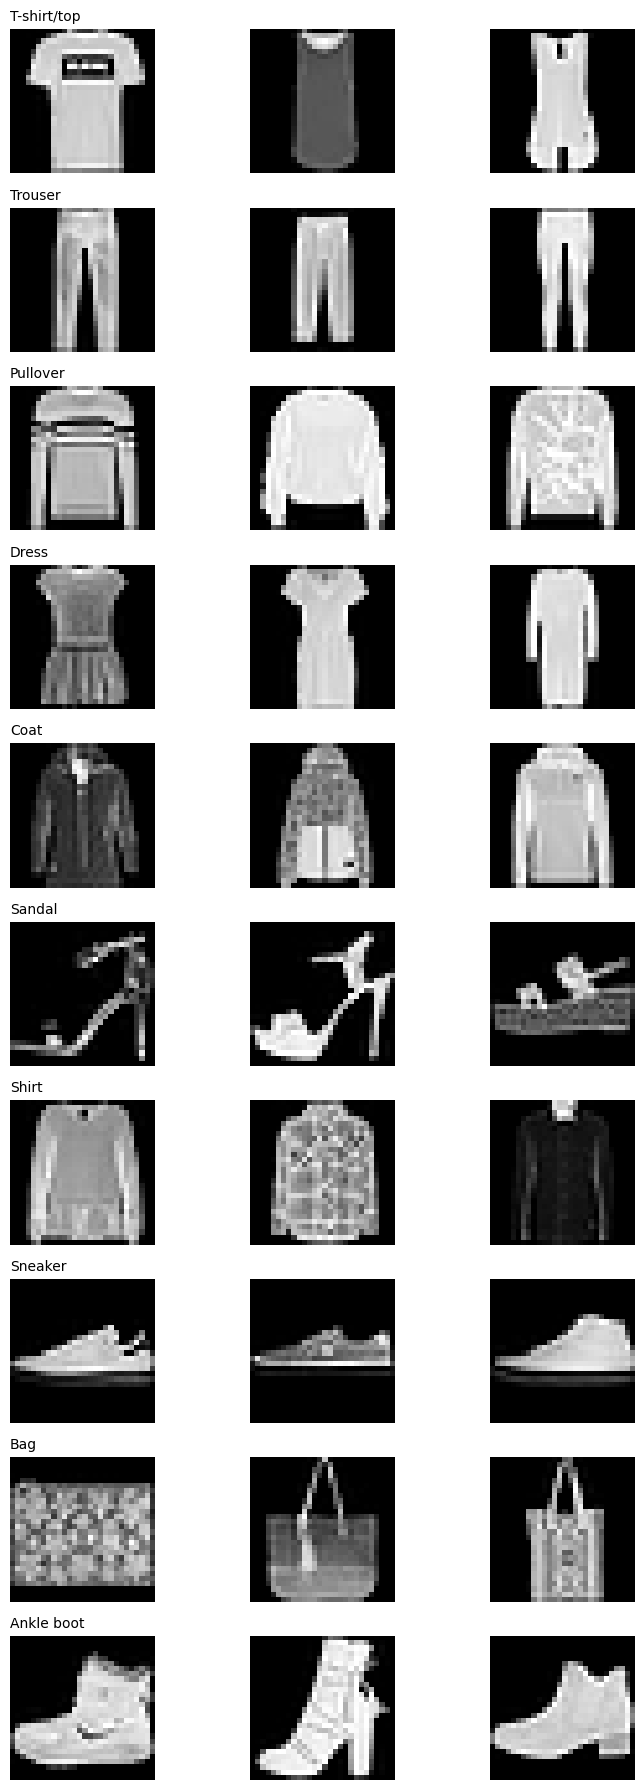

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# store first 3 indices for each class
indices_per_class = {i: [] for i in range(10)} # Dictionary -> Key= Class Label, Value=List of indices

for idx in range(len(traindata)):
    _, label = traindata[idx]
    if len(indices_per_class[label]) < 3:
        indices_per_class[label].append(idx)

    # stop early once we have 3 from every class
    if all(len(indices_per_class[c]) == 3 for c in range(10)):
        break

# plot: 10 rows (classes) x 3 columns (samples)
fig, axes = plt.subplots(10, 3, figsize=(8, 18))

for c in range(10):
    for j in range(3):
        img, label = traindata[indices_per_class[c][j]]
        axes[c, j].imshow(img, cmap="gray") # Dataset has Grayscale Images. You don't need the cmap parameter for RGB images
        axes[c, j].axis("off")
        if j == 0:
            axes[c, j].set_title(class_names[c], loc="left", fontsize=10)

plt.tight_layout()
plt.show()

**Preprocessing and Data Preparation**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                       # Convert to tensor: PIL Image -> (C, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

trainset=datasets.FashionMNIST('data',train=True,download=True,transform=transform)
testset=datasets.FashionMNIST('data',train=False,download=True, transform=transform)

# Randomly split training data into 80% train, 20% validation
val_size = int(0.2*len(trainset)) # Cast to int
train_size = len(trainset) - val_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    trainset, [train_size, val_size], generator=generator
)

#Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

**CNN Architecture**

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.3):
        super(CNN, self).__init__()

        #CONVOLUTION
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        #BATCHNORM
        self.bn1   = nn.BatchNorm2d(64)
        self.bn2   = nn.BatchNorm2d(128)

        #POOLING
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)   # 28->14->7
        #self.avgpool=nn.AvgPool2d(kernel_size=2, stride=None, padding=0)
        #self.gap=nn.AdaptiveAvgPool2d(output_size=(1,1))   # Provide Output Size (H,W) -> Automatically calculates kernel size, padding, stride to get output shape

        #DROPOUT
        self.dropout = nn.Dropout(0.3)

        #FULLY CONNECTED LAYERS
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Check model architecture
model = CNN(num_classes=10)
print(model)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 28, 28]          640
├─BatchNorm2d: 1-2                       [64, 64, 28, 28]          128
├─MaxPool2d: 1-3                         [64, 64, 14, 14]          --
├─Conv2d: 1-4                            [64, 128, 14, 14]         73,856
├─BatchNorm2d: 1-5                       [64, 128, 14, 14]         256
├─MaxPool2d: 1-6                         [64, 128, 7, 7]           --
├─Linear: 1-7                            [64, 128]                 802,944
├─Dropout: 1-8                           [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
Total params: 879,114
Trainable params: 879,114
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.01
Input size (MB): 0.20
Forward/backward pass size (MB): 77.14
Params size (MB): 3.52
Estimated Tota

**Loss function and Training**

In [ ]:
criterion = nn.CrossEntropyLoss() # For multi class classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

Epoch 1/8 - Train Loss: 0.4171, Val Loss: 0.2986
Epoch 2/8 - Train Loss: 0.2814, Val Loss: 0.2379
Epoch 3/8 - Train Loss: 0.2357, Val Loss: 0.2359
Epoch 4/8 - Train Loss: 0.2084, Val Loss: 0.2353
Epoch 5/8 - Train Loss: 0.1793, Val Loss: 0.2338
Epoch 6/8 - Train Loss: 0.1583, Val Loss: 0.2456
Epoch 7/8 - Train Loss: 0.1430, Val Loss: 0.2477
Epoch 8/8 - Train Loss: 0.1193, Val Loss: 0.2677


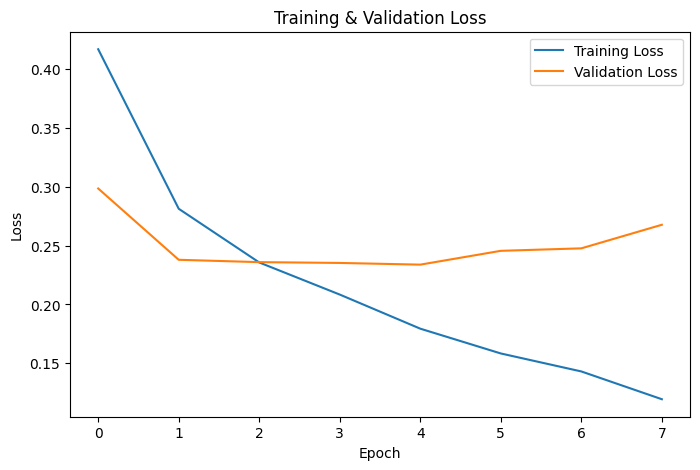

In [ ]:
num_epochs = 8
train_losses, val_losses = [], []

model = model.to(device)
# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

**Task 6 - Model Evaluation**

Test Accuracy: 0.9183
Test Precision: 0.9200
Test Recall: 0.9183
Test F1-Score: 0.9185


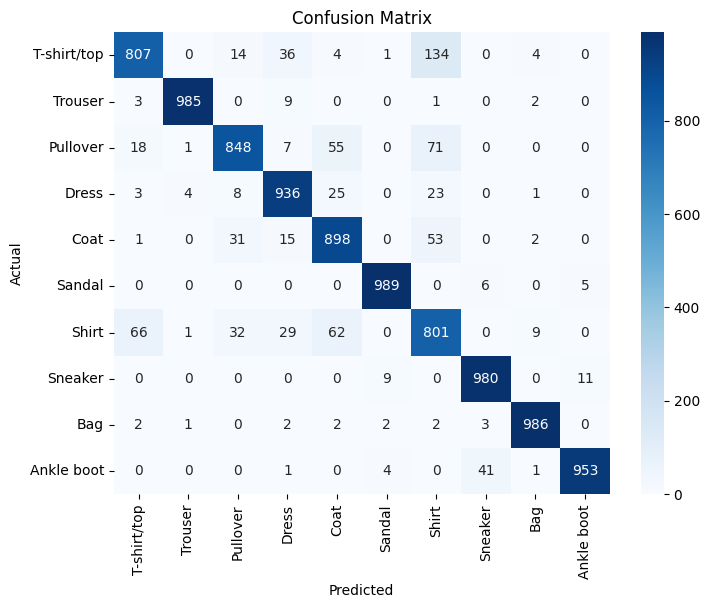

In [ ]:
# Testing
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()  # Ensure labels are long

        outputs = model(inputs)
        outputs = F.softmax(outputs, dim=1) # Model outputs logits, for prediction- using softmax

        # Prediction
        _, preds = torch.max(outputs, 1)

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()